# Zastosowanie metod uczenia maszynowego w analizie zmian temperatury w Europie

### Import potrzebnych bibliotek

In [1]:
import cdsapi
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
import geopandas as gpd
from shapely.geometry import Point
import regionmask


### Pobranie plików

In [2]:

#dataset = "insitu-gridded-observations-europe"
'''request = {
    "product_type": "ensemble_mean",
    "variable": [
        "mean_temperature",
        "minimum_temperature",
        "maximum_temperature",
        "precipitation_amount",
        "relative_humidity",
        "wind_speed"
    ],
    "grid_resolution": "0_1deg",
    "period": "full_period",
    "version": [
        "30_0e",
        "25_0e"
    ]
}'''

#client = cdsapi.Client()
#client.retrieve(dataset, request).download()


'request = {\n    "product_type": "ensemble_mean",\n    "variable": [\n        "mean_temperature",\n        "minimum_temperature",\n        "maximum_temperature",\n        "precipitation_amount",\n        "relative_humidity",\n        "wind_speed"\n    ],\n    "grid_resolution": "0_1deg",\n    "period": "full_period",\n    "version": [\n        "30_0e",\n        "25_0e"\n    ]\n}'

### Wczytanie pliku ze średnią temperaturą

In [3]:
netcdf_file2 = 'climate_data/tg_ens_mean_0.1deg_reg_v30.0e.nc'
xrds2 = xr.open_dataset(netcdf_file2)
print(xrds2)


<xarray.Dataset> Size: 36GB
Dimensions:    (time: 27210, latitude: 465, longitude: 705)
Coordinates:
  * latitude   (latitude) float64 4kB 25.05 25.15 25.25 ... 71.25 71.35 71.45
  * longitude  (longitude) float64 6kB -24.95 -24.85 -24.75 ... 45.35 45.45
  * time       (time) datetime64[ns] 218kB 1950-01-01 1950-01-02 ... 2024-06-30
Data variables:
    tg         (time, latitude, longitude) float32 36GB ...
Attributes:
    E-OBS_version:  30.0e
    Conventions:    CF-1.4
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Fri Aug 30 10:36:09 2024: ncks --no-abc -d time,0,27209 /...
    NCO:            netCDF Operators version 5.1.8 (Homepage = http://nco.sf....


### Wizualizacje temperatury z przykładowych dni

In [4]:
data_day = xrds2["tg"].sel(time="1950-01-01")
valid_points = (~data_day.isnull()).sum().compute()
print(int(valid_points.values))


125675


In [5]:
valid_points = ~np.isnan(data_day)
valid_points

<xarray.DataArray 'tg' (latitude: 465, longitude: 705)> Size: 328kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * latitude   (latitude) float64 4kB 25.05 25.15 25.25 ... 71.25 71.35 71.45
  * longitude  (longitude) float64 6kB -24.95 -24.85 -24.75 ... 45.35 45.45
    time       datetime64[ns] 8B 1950-01-01
Attributes:
    units:          Celsius
    long_name:      mean temperature
    standard_name:  air_temperature

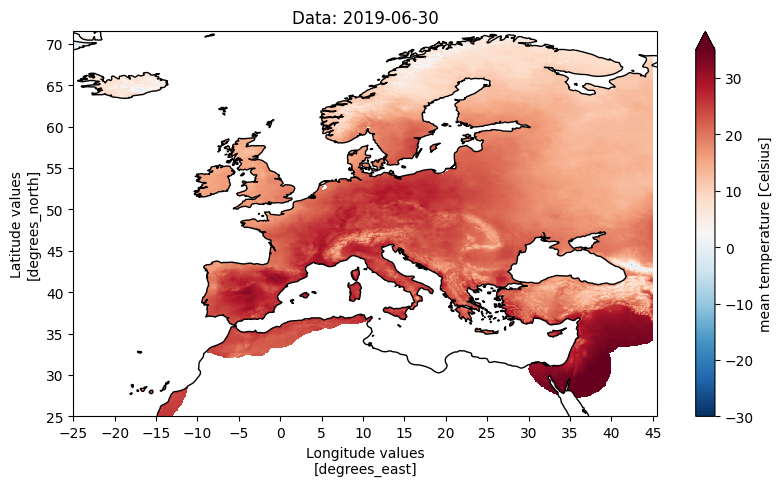

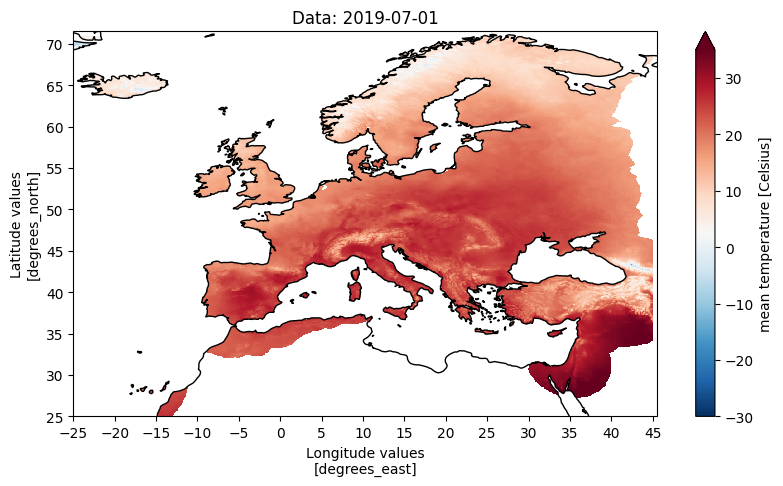

In [6]:
# data początkowa
start_date = pd.to_datetime("2019-06-30")
global_min = -30
global_max = 35

for i in range(2):
    desired_date = start_date + pd.Timedelta(days=i)
    data_for_desired_date = xrds2.sel(time=desired_date, method='nearest')

    df = data_for_desired_date['tg'].to_dataframe().dropna(subset=['tg'])
    
    # rysowanie mapy
    plt.figure(figsize=(10,5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_xticks(range(-25, 50, 5), crs=ccrs.PlateCarree())
    ax.set_yticks(range(25, 75, 5), crs=ccrs.PlateCarree())
    
    # ustawienie globalnej skali kolorów
    data_for_desired_date['tg'].plot(ax=ax, vmin=global_min, vmax=global_max, cmap='RdBu_r')

    # wykres temperatury 
    plt.title(f"Data: {desired_date.strftime('%Y-%m-%d')}")
    plt.show()

### Otworzenie lokalnego klastra DASK

In [7]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=2, threads_per_worker=2, memory_limit='4GB')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 4,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56692,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:56719,Total threads: 2
Dashboard: http://127.0.0.1:56721/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:56696,


### Usunięcie punktów z brakami

In [8]:
import xarray as xr

xrds2 = xr.open_dataset(netcdf_file2)

xrds2 = xrds2.chunk({
    "time": 365,       # 1 rok na chunk
    "latitude": 100,
    "longitude": 100
})

temp_y = xrds2['tg']  # ('year', 'lat', 'lon')

valid_mask = temp_y.notnull().all(dim='time')

tg_valid = temp_y.where(valid_mask)
tg_valid

<xarray.DataArray 'tg' (time: 27210, latitude: 465, longitude: 705)> Size: 36GB
dask.array<where, shape=(27210, 465, 705), dtype=float32, chunksize=(365, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 4kB 25.05 25.15 25.25 ... 71.25 71.35 71.45
  * longitude  (longitude) float64 6kB -24.95 -24.85 -24.75 ... 45.35 45.45
  * time       (time) datetime64[ns] 218kB 1950-01-01 1950-01-02 ... 2024-06-30
Attributes:
    units:          Celsius
    long_name:      mean temperature
    standard_name:  air_temperature

In [9]:
import dask.array as da

netcdf_file2 = 'climate_data/tg_ens_mean_0.1deg_reg_v30.0e.nc'
xrds2 = xr.open_dataset(netcdf_file2, chunks={'time': 100})

valid_mask = xrds2['tg'].notnull().all(dim='time')
valid_mask = valid_mask.compute()  


xrds_valid = xrds2['tg'].where(valid_mask, drop=True)


### Wizualizacja po usunięciu punktów z brakami

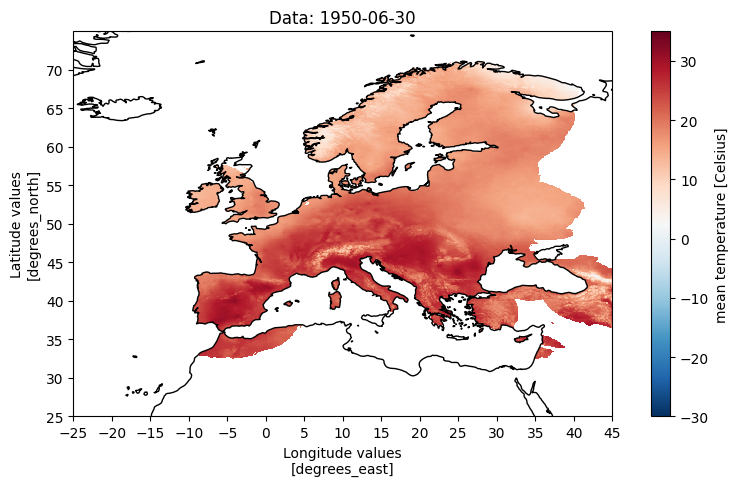

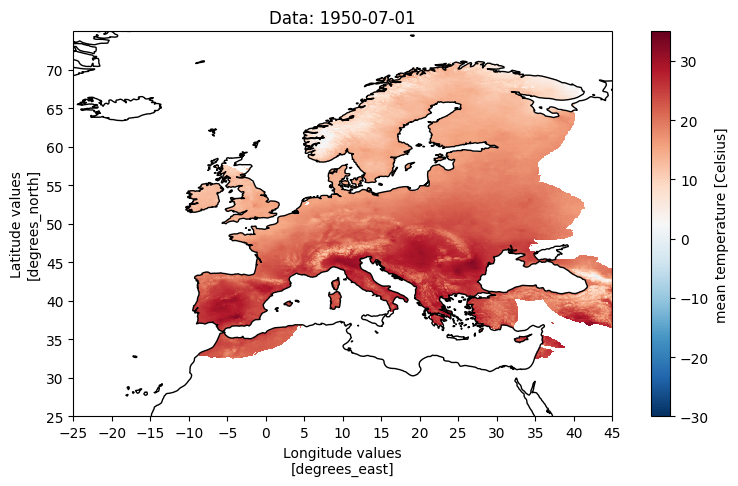

In [10]:
start_date = pd.to_datetime("1950-06-30")
global_min = -30
global_max = 35

for i in range(2):
    desired_date = start_date + pd.Timedelta(days=i)
    data_for_desired_date = xrds_valid.sel(time=desired_date, method='nearest')

    plt.figure(figsize=(10,5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([-25, 45, 25, 75], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_xticks(range(-25, 50, 5), crs=ccrs.PlateCarree())
    ax.set_yticks(range(25, 75, 5), crs=ccrs.PlateCarree())

    data_for_desired_date.plot(
        ax=ax,
        vmin=global_min,
        vmax=global_max,
        cmap='RdBu_r'
    )

    plt.title(f"Data: {desired_date.strftime('%Y-%m-%d')}")
    plt.show()


### Przycięcie do granic Europy przy użyciu Natural Earth data

In [11]:
ds = xrds_valid 

# 1. Wczytanie shapefile świata i wybranie Europy
world = gpd.read_file("C:/Users/aleks/Desktop/AGH//IAD/inzynierka/ne_50m_admin_0_countries.shp")
europe_shape = world[world["CONTINENT"] == "Europe"].to_crs("EPSG:4326")

# 2. Utworzenie regionmask z geometrią krajów
regions = regionmask.Regions(europe_shape['geometry'], names=europe_shape['NAME'])

# 3. Utworzenie maski 
mask = regions.mask(ds['longitude'], ds['latitude'], method="shapely")  
# maska ma wymiary (lat, lon)

# 4. Zastosowanie maski do danych 
europe_masked = ds.where(mask.notnull(), drop=False)


C:\Users\aleks\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py:3577: FutureWarning: The ``method`` argument is internal and  will be removed in the future. Setting the ``method`` (i.e. backend) should not be necessary. Please raise an issue if you require it.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Wizualizacja zbioru po przycięciu

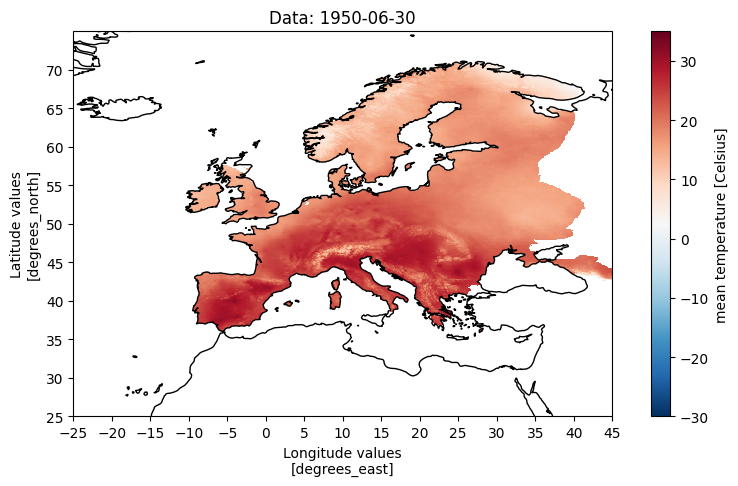

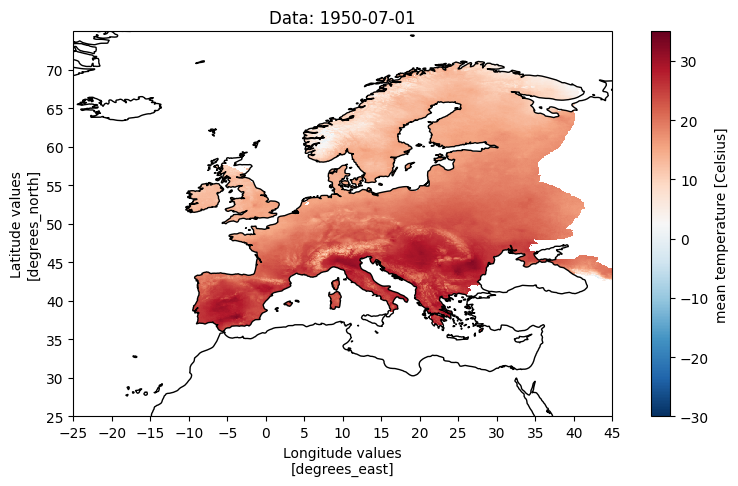

In [12]:
europe_tg = europe_masked

start_date = pd.to_datetime("1950-06-30")
global_min = -30
global_max = 35

for i in range(2):
    desired_date = start_date + pd.Timedelta(days=i)
    
    data_for_desired_date = europe_tg.sel(time=desired_date, method='nearest')

    plt.figure(figsize=(10,5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    ax.set_extent([-25, 45, 25, 75], crs=ccrs.PlateCarree())
    
    ax.coastlines()
    ax.set_xticks(range(-25, 50, 5), crs=ccrs.PlateCarree())
    ax.set_yticks(range(25, 75, 5), crs=ccrs.PlateCarree())

    # wizualizacja
    data_for_desired_date.plot(
        ax=ax,
        vmin=global_min,
        vmax=global_max,
        cmap='RdBu_r'
    )
    
    plt.title(f"Data: {desired_date.strftime('%Y-%m-%d')}")
    plt.show()


### Zapis do pliku

In [13]:
data_day = europe_masked.sel(time="1985-01-01")
valid_points = (~data_day.isnull()).sum().compute()
print(int(valid_points.values))


91703


In [14]:
# Zapis do pliku NetCDF
#output_file = "europe_masked.nc"
#europe_masked.to_netcdf(output_file)

#print(f"Zapisano przefiltrowany dataset do pliku: {output_file}")


In [15]:
file = 'europe_masked.nc'
masked = xr.open_dataset(file)
print(masked)


data_day = masked["tg"].sel(time="1950-01-01")
valid_points = (~data_day.isnull()).sum().compute()
print(int(valid_points.values))


<xarray.Dataset> Size: 23GB
Dimensions:    (time: 27210, latitude: 385, longitude: 555)
Coordinates:
  * latitude   (latitude) float64 3kB 32.55 32.65 32.75 ... 70.75 70.85 70.95
  * longitude  (longitude) float64 4kB -10.45 -10.35 -10.25 ... 44.85 44.95
  * time       (time) datetime64[ns] 218kB 1950-01-01 1950-01-02 ... 2024-06-30
Data variables:
    tg         (time, latitude, longitude) float32 23GB ...
0


### Obliczenie średniej temperatury w całej Europie w każdym dniu 


In [16]:
daily_mean = europe_tg.mean(dim=["latitude", "longitude"], skipna=True)
print(daily_mean)
df = daily_mean.to_dataframe().reset_index()
#df.to_excel("srednia_dzienna.xlsx", index=False)


<xarray.DataArray 'tg' (time: 27210)> Size: 109kB
dask.array<mean_agg-aggregate, shape=(27210,), dtype=float32, chunksize=(100,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 218kB 1950-01-01 1950-01-02 ... 2024-06-30


<function matplotlib.pyplot.show(close=None, block=None)>

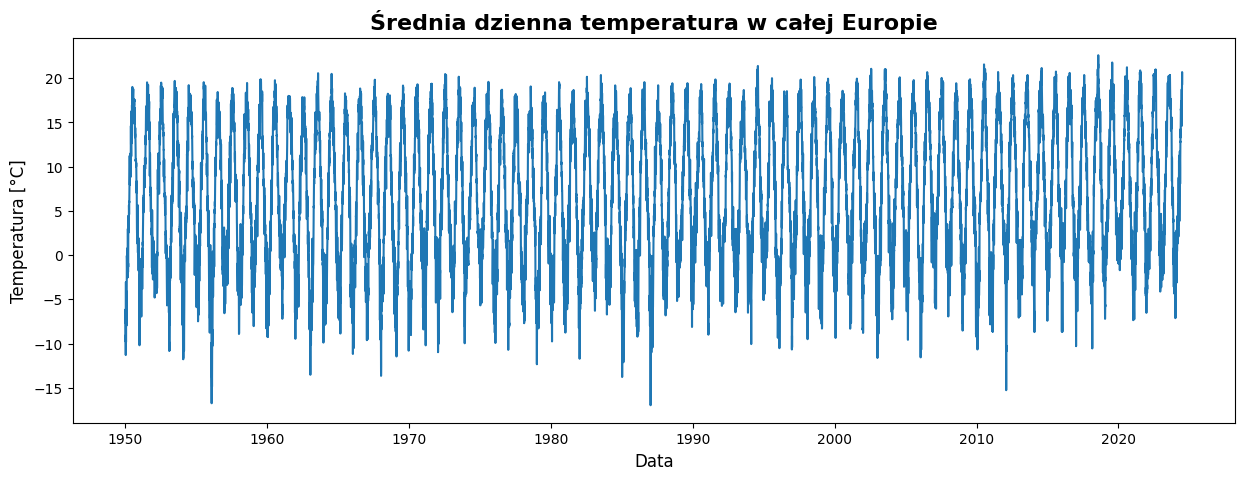

In [17]:
dane = pd.read_excel("srednia_dzienna.xlsx")
#dane = dane[dane["time"] != 2024]
dane.head(5)
fig=plt.figure(figsize=(15,5))
plt.plot(dane['time'], dane['tg'])
plt.title("Średnia dzienna temperatura w całej Europie", fontsize=16, fontweight='bold')
plt.xlabel("Data", fontsize=12)
plt.ylabel("Temperatura [°C]", fontsize=12)

plt.show


### Dekompozycja klasyczna

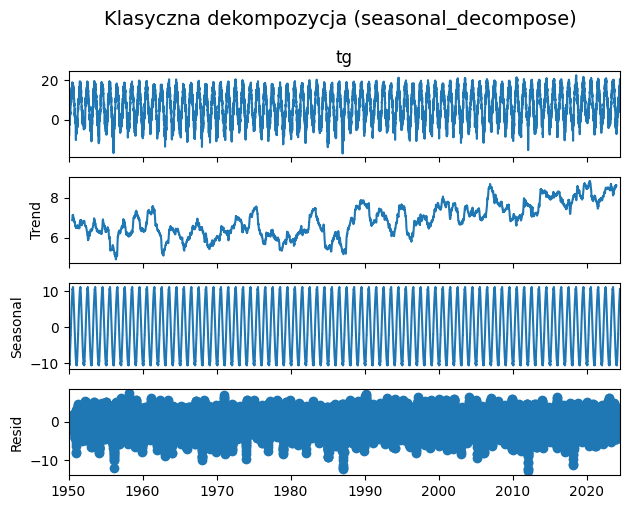

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
dane_d = dane.sort_values("time")
dane_d = dane_d.set_index("time")

result = seasonal_decompose(dane_d['tg'], model='additive', period=365)

# Wykresy
fig= result.plot()
fig.suptitle('        Klasyczna dekompozycja (seasonal_decompose)',y=1.05, fontsize=14)
plt.show()


In [19]:
#test
from scipy.stats import shapiro
result_k = seasonal_decompose(dane['tg'], model='additive', period=365)
residuals = result_k.resid.dropna()

stat, p_value = shapiro(residuals)

print(f"Statystyka testowa: {stat:.4f}")
print(f"p-value: {p_value:.4f}")


Statystyka testowa: 0.9888
p-value: 0.0000


C:\Users\aleks\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 26846.
  res = hypotest_fun_out(*samples, **kwds)


In [20]:
from scipy.stats import kstest

res_std = (residuals - np.mean(residuals)) / np.std(residuals)

stat_ks, p_value_ks = kstest(res_std, 'norm')

print(f"KS statystyka: {stat_ks:.4f}")
print(f"KS p-value: {p_value_ks:.4f}")


KS statystyka: 0.0278
KS p-value: 0.0000


### Dekompozycja przy użyciu LOESS

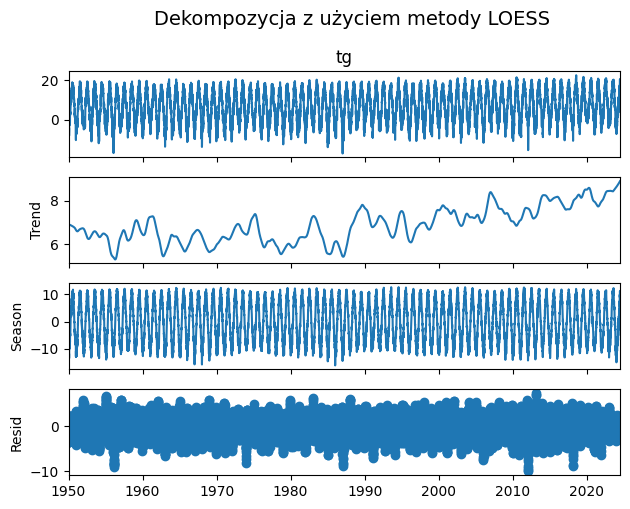

In [21]:
from statsmodels.tsa.seasonal import STL
stl = STL(dane_d['tg'], period=365)  
result = stl.fit()
fig = result.plot()
fig.suptitle("            Dekompozycja z użyciem metody LOESS", y=1.05,  fontsize=14 )
plt.show()


In [22]:
from scipy.stats import shapiro

stl = STL(dane_d['tg'], period=365)  
result_s = stl.fit()
residuals_stl = result_s.resid.dropna()

stat_stl, p_value_stl = shapiro(residuals_stl)

print(f"STL – statystyka Shapiro-Wilka: {stat_stl:.4f}")
print(f"STL – p-value: {p_value_stl:.4f}")


STL – statystyka Shapiro-Wilka: 0.9886
STL – p-value: 0.0000


C:\Users\aleks\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 27210.
  res = hypotest_fun_out(*samples, **kwds)


Porównanie

In [23]:
res_std = (residuals_stl - np.mean(residuals_stl)) / np.std(residuals_stl)

stat_ks, p_value_ks = kstest(res_std, 'norm')

print(f"KS statystyka: {stat_ks:.4f}")
print(f"KS p-value: {p_value_ks:.4f}")


KS statystyka: 0.0306
KS p-value: 0.0000


In [24]:
resid_classic = result_k.resid.dropna()
resid_stl = result_s.resid.dropna()

var_classic = np.var(resid_classic)
var_stl = np.var(resid_stl)

print(f"Wariancja reszt – klasyczna: {var_classic:.4f}")
print(f"Wariancja reszt – STL: {var_stl:.4f}")


Wariancja reszt – klasyczna: 4.7019
Wariancja reszt – STL: 2.8104


In [25]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_classic = acorr_ljungbox(resid_classic, lags=[30], return_df=True)
lb_stl = acorr_ljungbox(resid_stl, lags=[30], return_df=True)

print("Klasyczna dekompozycja:")
print(lb_classic)

print("\nSTL:")
print(lb_stl)


Klasyczna dekompozycja:
         lb_stat  lb_pvalue
30  99201.304681        0.0

STL:
         lb_stat  lb_pvalue
30  78315.377496        0.0


### Minimalna i maksymalna średnia dzienna temperatura

In [26]:
min_temp = min(dane['tg'])
print(dane[dane['tg'] == min_temp ])

max_temp = max(dane['tg'])
print(dane[dane['tg'] == max_temp ])

            time        tg
13522 1987-01-09 -16.96213
            time         tg
25048 2018-07-31  22.591099


### Średnia temperatura w każdym miesiącu

średnie miesięczne w każdym roku

In [27]:
dane.head()

,time,tg
0,1950-01-01,-7.661587
1,1950-01-02,-6.964582
2,1950-01-03,-6.149366
3,1950-01-04,-7.695820
4,1950-01-05,-9.485427


In [28]:
dane["month"] = dane["time"].dt.month_name()
dane["month_num"] = dane["time"].dt.month

month_year_avg = dane.groupby([ 'month_num',"month"])["tg"].mean().reset_index()
month_year_avg = month_year_avg.drop(columns="month_num")
month_year_avg

,month,tg
0,January,-3.402384
1,February,-2.649824
2,March,0.931146
3,April,5.953216
4,May,11.214740
5,June,15.398467
6,July,17.579876
7,August,16.712298
8,September,12.447586
9,October,7.369560


In [29]:
miesiace_pl = {
    1: "Styczeń",
    2: "Luty",
    3: "Marzec",
    4: "Kwiecień",
    5: "Maj",
    6: "Czerwiec",
    7: "Lipiec",
    8: "Sierpień",
    9: "Wrzesień",
    10: "Październik",
    11: "Listopad",
    12: "Grudzień"
}

dane["month_num"] = dane["time"].dt.month
dane["month"] = dane["month_num"].map(miesiace_pl)

month_year_avg = (
    dane
    .groupby(["month_num", "month"])["tg"]
    .mean()
    .reset_index()
    .sort_values("month_num")
    .drop(columns="month_num")
)
month_year_avg

,month,tg
0,Styczeń,-3.402384
1,Luty,-2.649824
2,Marzec,0.931146
3,Kwiecień,5.953216
4,Maj,11.214740
5,Czerwiec,15.398467
6,Lipiec,17.579876
7,Sierpień,16.712298
8,Wrzesień,12.447586
9,Październik,7.369560


średnia temperatura dla miesięcy w całej historii 

In [30]:
dane["year"] = dane["time"].dt.year
month_year_avg = dane.groupby(["year", "month"])["tg"].mean().reset_index()
month_year_avg

,year,month,tg
0,1950,Czerwiec,15.618931
1,1950,Grudzień,-1.522509
2,1950,Kwiecień,7.236494
3,1950,Lipiec,17.272040
4,1950,Listopad,2.417180
...,...,...,...
889,2024,Kwiecień,7.618557
890,2024,Luty,1.324332
891,2024,Maj,12.880354
892,2024,Marzec,4.023554


### Heatmapa średniej miesięcznej temperatury

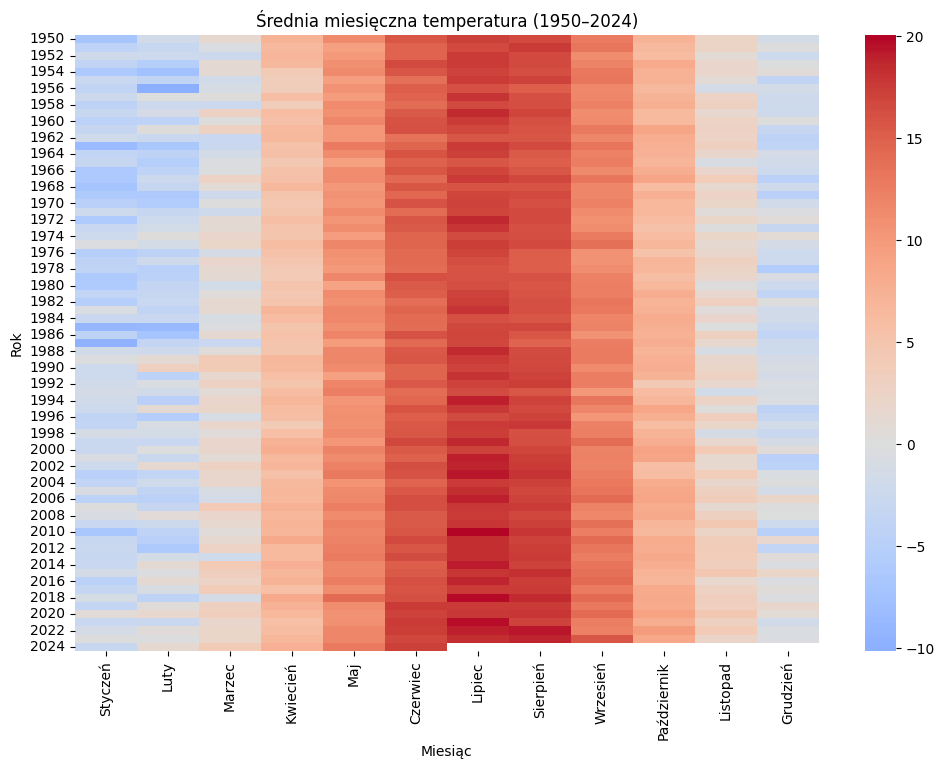

In [31]:
import seaborn as sns

pivot = month_year_avg.pivot(index="year", columns="month", values="tg")

order = ["Styczeń","Luty","Marzec","Kwiecień","Maj","Czerwiec","Lipiec","Sierpień","Wrzesień","Październik","Listopad","Grudzień"]
pivot = pivot[order]

plt.figure(figsize=(12,8))
sns.heatmap(pivot, cmap="coolwarm", center=0)
plt.title("Średnia miesięczna temperatura (1950–2024)")
plt.xlabel("Miesiąc")
plt.ylabel("Rok")
plt.show()


### Miesięczne anomalie w porównaniu do średniej

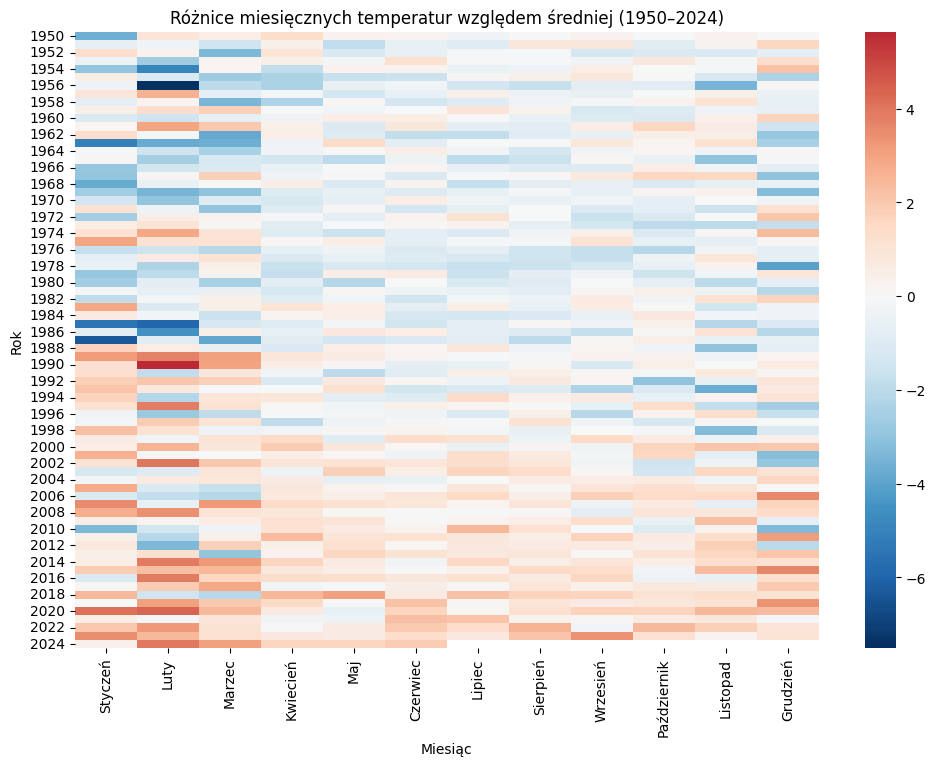

In [32]:
mean_by_month = month_year_avg.groupby("month")["tg"].mean()

month_year_avg["anomaly"] = month_year_avg.apply(lambda r: r["tg"] - mean_by_month[r["month"]], axis=1)

pivot_anom = month_year_avg.pivot(index="year", columns="month", values="anomaly")[order]

plt.figure(figsize=(12,8))
sns.heatmap(pivot_anom, cmap="RdBu_r", center=0)
plt.title("Różnice miesięcznych temperatur względem średniej (1950–2024)")
plt.xlabel("Miesiąc")
plt.ylabel("Rok")
plt.show()


### Średnia roczna temperatura w Europie

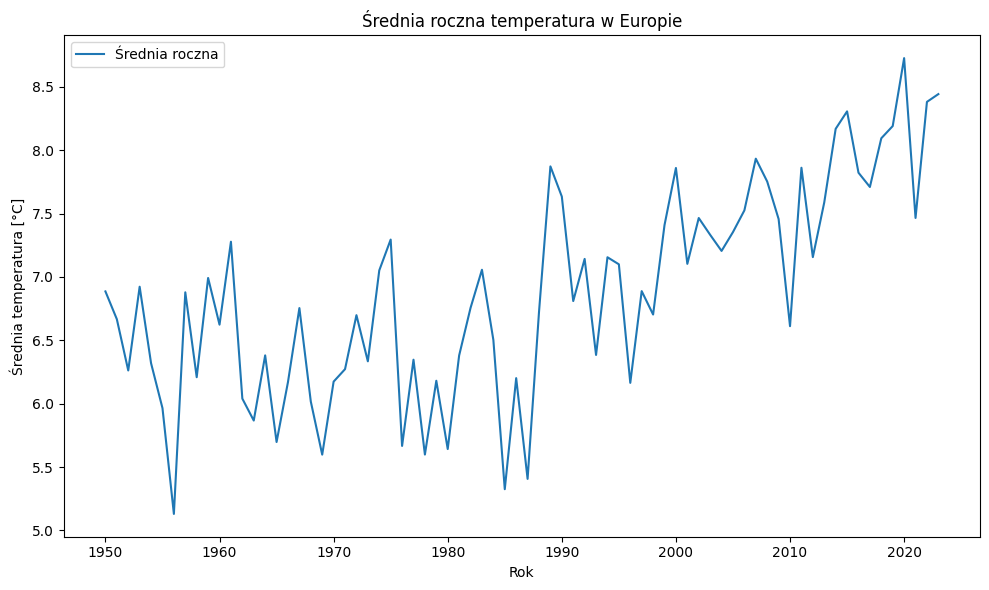

In [33]:
dane["year"] = dane["time"].dt.year
dane = dane[dane["year"] != 2024]

season_year_avg = dane.groupby(["year"])["tg"].mean().reset_index()

#zapis do csv
#season_year_avg.to_csv("srednia_roczna_temperatura.csv", index=False)

# Wizualizacja
plt.figure(figsize=(10, 6))
plt.plot(season_year_avg["year"], season_year_avg["tg"], label="Średnia roczna")
plt.title("Średnia roczna temperatura w Europie")
plt.xlabel("Rok")
plt.ylabel("Średnia temperatura [°C]")
plt.legend()
plt.tight_layout()
plt.show()


### Wykrywanie punktu zmiany

In [34]:
import ruptures as rpt

# Dopasowanie modelu PELT
dane_p_z = season_year_avg["tg"].values  

# Zmienne pomocnicze
years = season_year_avg["year"]
data = season_year_avg["tg"]


algo = rpt.Pelt(model="l2").fit(dane_p_z)

# Sprawdzenie stabilności dla kilku wartości pen
for pen in [1, 3, 5, 10]:
    result = algo.predict(pen=pen)
    print(f"pen={pen}: {result}")



pen=1: [40, 50, 65, 74]
pen=3: [40, 65, 74]
pen=5: [50, 74]
pen=10: [50, 74]


In [35]:
result = algo.predict(pen=5)
breakpoints = [bp for bp in result if bp < len(season_year_avg)]

if len(breakpoints) == 0:
    raise ValueError("Nie wykryto punktu zmiany")

cp = breakpoints[0]
break_year = years.iloc[cp]

print(f"Wybrany punkt zmiany: indeks={cp}, rok={break_year}")


Wybrany punkt zmiany: indeks=50, rok=2000


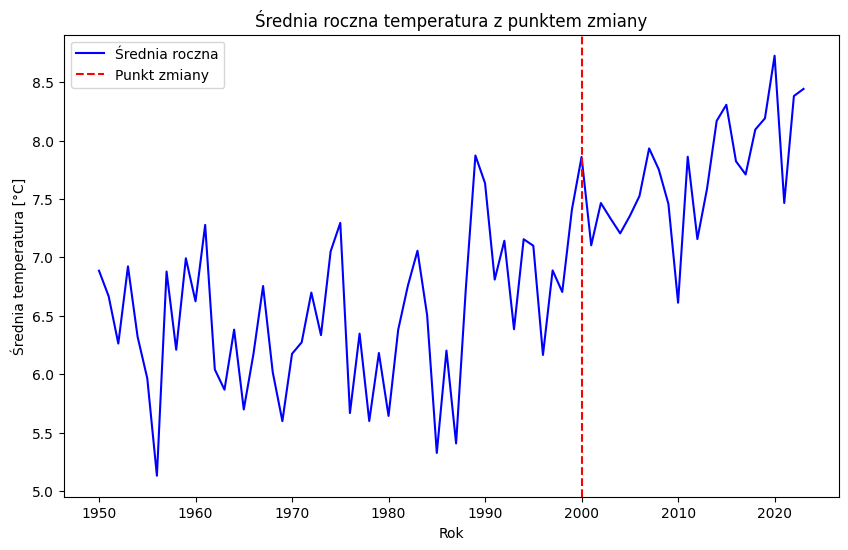

In [36]:
plt.figure(figsize=(10,6))
plt.plot(years, data, label="Średnia roczna", color='blue')
for cp in result:
    if cp < len(data):  
        plt.axvline(x=season_year_avg["year"][cp], color='red', linestyle='--', label="Punkt zmiany")
plt.title("Średnia roczna temperatura z punktem zmiany")
plt.xlabel("Rok")
plt.ylabel("Średnia temperatura [°C]")
plt.legend()
plt.show()


### Nachylenie przed i po

In [37]:
import statsmodels.api as sm
import pandas as pd


# Tworzymy DataFrame
df = pd.DataFrame({
    "year": years,
    "temp": data
})

df["post"] = (df["year"] >= break_year).astype(int)
df["year_post"] = df["year"] * df["post"]
X = sm.add_constant(df[["year", "post", "year_post"]])
y = df["temp"]

# Estymacja z odpornymi błędami HAC (Newey-West)
model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 3})

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                   temp   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     61.82
Date:                Thu, 19 Feb 2026   Prob (F-statistic):           1.21e-19
Time:                        00:57:28   Log-Likelihood:                -58.124
No. Observations:                  74   AIC:                             124.2
Df Residuals:                      70   BIC:                             133.5
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -13.9192     12.160     -1.145      0.2

In [38]:
beta1 = model.params["year"]
beta3 = model.params["year_post"]

slope_before = beta1
slope_after = beta1 + beta3

print(f"Nachylenie przed punktem zmiany: {slope_before:.4f} °C/rok")
print(f"Nachylenie po punkcie zmiany: {slope_after:.4f} °C/rok")
print(f"Zmiana nachylenia: {beta3:.4f} °C/rok")

print("\nCzy zmiana trendu jest istotna statystycznie?")
print(f"p-value dla zmiany nachylenia (year_post): {model.pvalues['year_post']:.4f}")


Nachylenie przed punktem zmiany: 0.0103 °C/rok
Nachylenie po punkcie zmiany: 0.0431 °C/rok
Zmiana nachylenia: 0.0327 °C/rok

Czy zmiana trendu jest istotna statystycznie?
p-value dla zmiany nachylenia (year_post): 0.0014


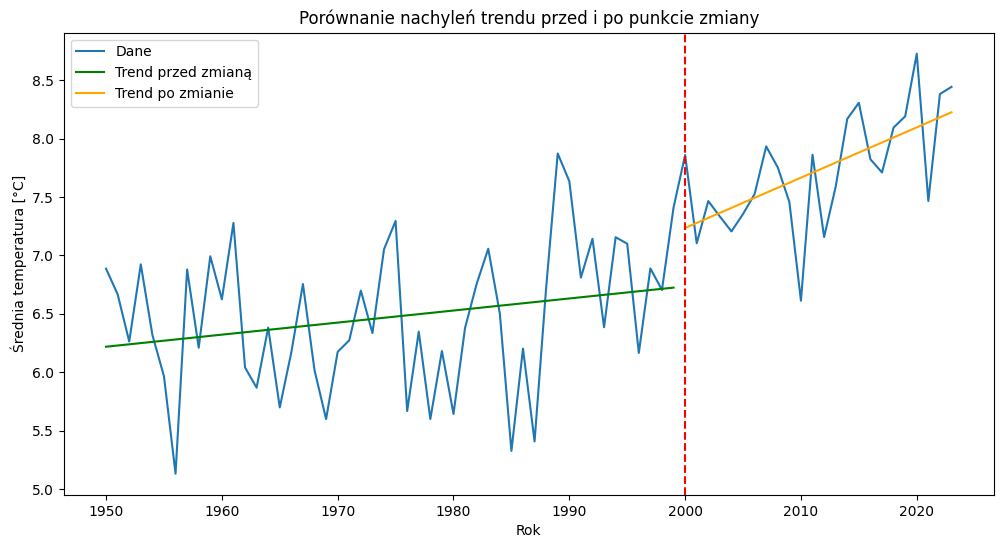

In [39]:
#Wizualizacja
years_before = df[df["post"] == 0]["year"]
years_after = df[df["post"] == 1]["year"]

pred_before = slope_before * years_before + model.params["const"]
pred_after = slope_after * years_after + \
             (model.params["const"] + model.params["post"])

plt.figure(figsize=(12,6))
plt.plot(df["year"], df["temp"], label="Dane", color="tab:blue")
plt.plot(years_before, pred_before, color="green", label="Trend przed zmianą")
plt.plot(years_after, pred_after, color="orange", label="Trend po zmianie")
plt.axvline(break_year, color="red", linestyle="--")

plt.title("Porównanie nachyleń trendu przed i po punkcie zmiany")
plt.xlabel("Rok")
plt.ylabel("Średnia temperatura [°C]")
plt.legend()
plt.show()


### Modelowanie

#### Podział na zbiory testowe i treningowe

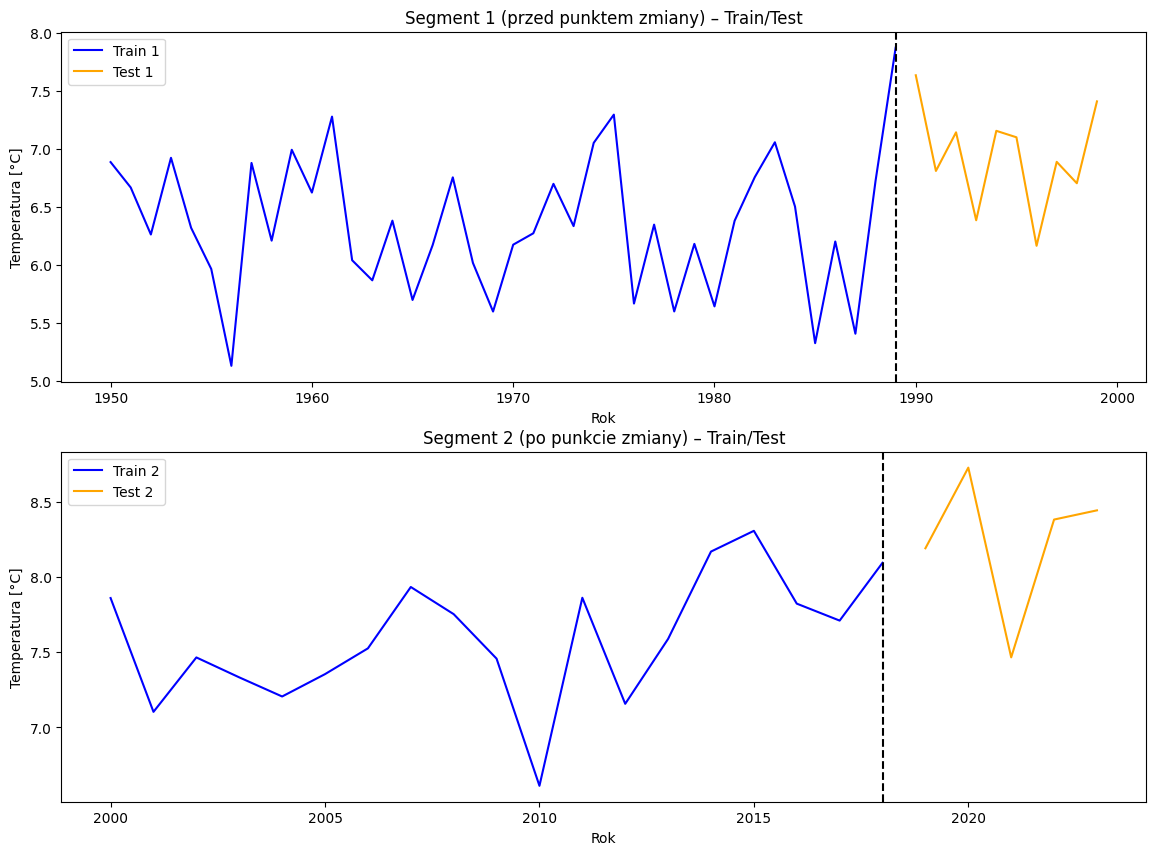

In [40]:
segment1 = df[df["year"] < break_year].copy()
segment2 = df[df["year"] >= break_year].copy()
split1 = int(len(segment1) * 0.8)

train1 = segment1.iloc[:split1]
test1 = segment1.iloc[split1:]
split2 = int(len(segment2) * 0.8)

train2 = segment2.iloc[:split2]
test2 = segment2.iloc[split2:]

#Wizualizacja
fig, axs = plt.subplots(2,1, figsize = (14,10))

axs[0].plot(train1["year"], train1["temp"], label="Train 1", color="blue")
axs[0].plot(test1["year"], test1["temp"], label="Test 1", color="orange")
axs[0].axvline(train1["year"].iloc[-1], linestyle="--", color="black")
axs[0].set_title("Segment 1 (przed punktem zmiany) – Train/Test")
axs[0].set_xlabel("Rok")
axs[0].set_ylabel("Temperatura [°C]")
axs[0].legend()
axs[0].legend(loc='upper left') 


axs[1].plot(train2["year"], train2["temp"], label="Train 2", color="blue")
axs[1].plot(test2["year"], test2["temp"], label="Test 2", color="orange")
axs[1].axvline(train2["year"].iloc[-1], linestyle="--", color="black")
axs[1].set_title("Segment 2 (po punkcie zmiany) – Train/Test")
axs[1].set_xlabel("Rok")
axs[1].set_ylabel("Temperatura [°C]")
axs[1].legend()
axs[1].legend(loc='upper left') 

plt.show()


#### Wybór modelu - N-BEATS

In [41]:
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler

# Segment 1
ts_train1 = TimeSeries.from_dataframe(train1, time_col="year", value_cols="temp")
ts_test1  = TimeSeries.from_dataframe(test1, time_col="year", value_cols="temp")

# Segment 2
ts_train2 = TimeSeries.from_dataframe(train2, time_col="year", value_cols="temp")
ts_test2  = TimeSeries.from_dataframe(test2, time_col="year", value_cols="temp")

#Skalowanie
scaler1 = Scaler()
scaler2 = Scaler()

ts_train1_scaled = scaler1.fit_transform(ts_train1)
ts_test1_scaled  = scaler1.transform(ts_test1)

ts_train2_scaled = scaler2.fit_transform(ts_train2)
ts_test2_scaled  = scaler2.transform(ts_test2)

#Modele
model1 = NBEATSModel(
    input_chunk_length=5,
    output_chunk_length=1,
    n_epochs=100,
    random_state=42,
)

model2 = NBEATSModel(
    input_chunk_length=5,
    output_chunk_length=1,
    n_epochs=100,
    random_state=42,
)


model1.fit(ts_train1_scaled)
model2.fit(ts_train2_scaled)

forecast1_scaled = model1.predict(len(ts_test1_scaled))
forecast2_scaled = model2.predict(len(ts_test2_scaled))

# Cofamy skalowanie
forecast1 = scaler1.inverse_transform(forecast1_scaled)
forecast2 = scaler2.inverse_transform(forecast2_scaled)


Importing plotly failed. Interactive plots will not work.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.0 M  | train
-------------------------------------------------------------
6.0 M     Trainable params
1.3 K     Non-trainable params
6.0 M     Total params
24.182    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
C:\Users\aleks\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning:

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.0 M  | train
-------------------------------------------------------------
6.0 M     Trainable params
1.3 K     Non-trainable params
6.0 M     Total params
24.182    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

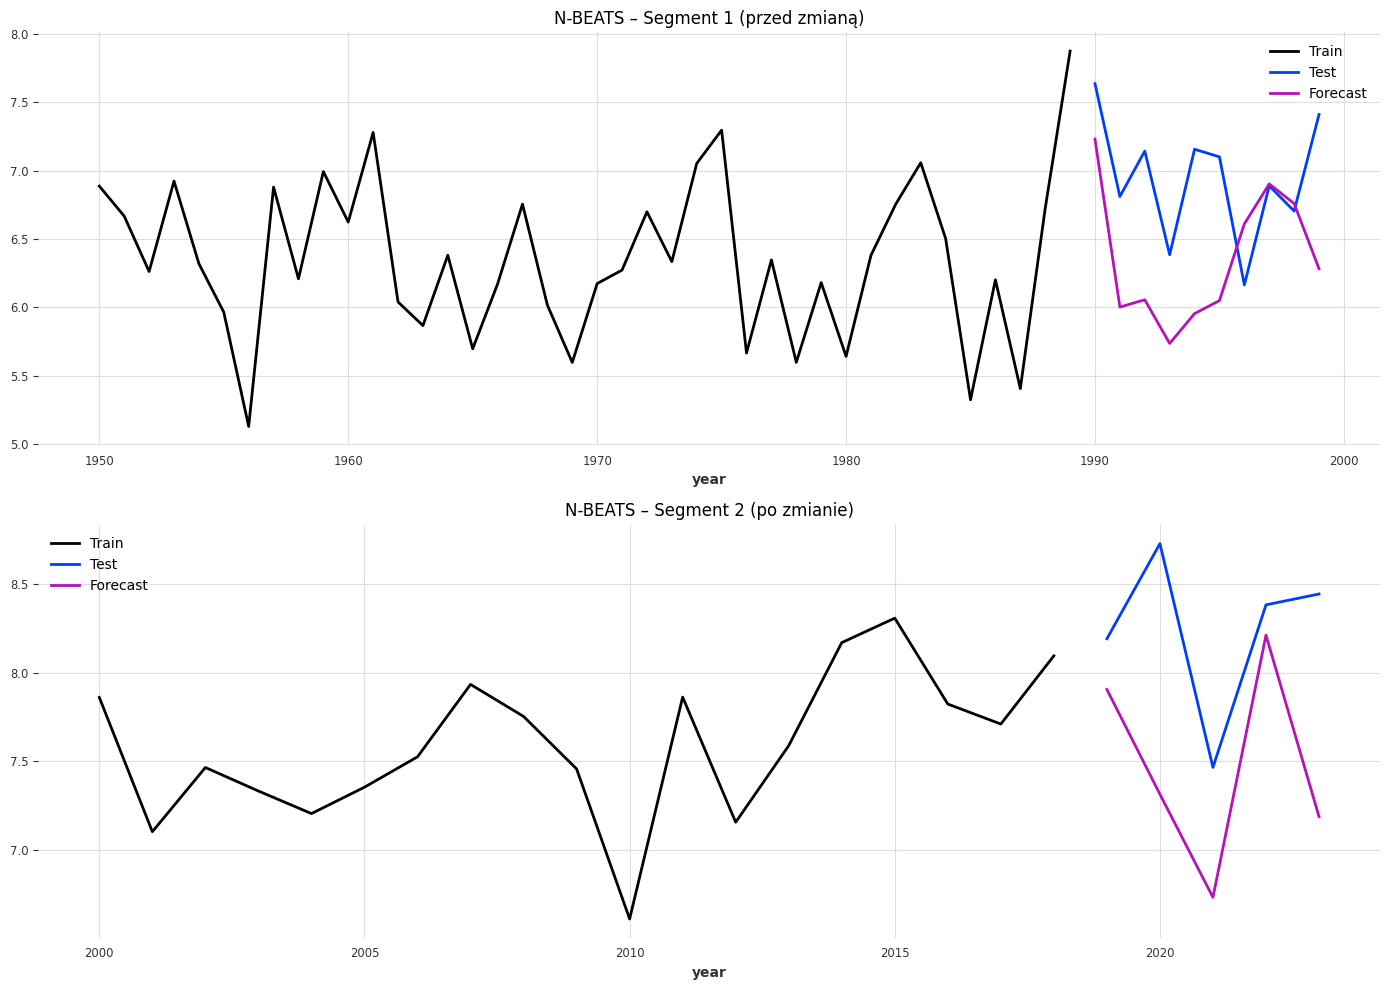

In [42]:
fig, axs = plt.subplots(2,1, figsize = (14,10))

#ssegment 1
ts_train1.plot(label="Train", ax=axs[0])
ts_test1.plot(label="Test", ax=axs[0])
forecast1.plot(label="Forecast", ax=axs[0])
axs[0].set_title("N-BEATS – Segment 1 (przed zmianą)")
axs[0].legend()

#segment2
ts_train2.plot(label="Train", ax=axs[1])
ts_test2.plot(label="Test", ax=axs[1])
forecast2.plot(label="Forecast", ax=axs[1])

axs[1].set_title("N-BEATS – Segment 2 (po zmianie)")
axs[1].legend()
plt.tight_layout()

plt.show()


#### Ocena modeli

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


def evaluate_forecast(actual_ts, forecast_ts):
    actual = actual_ts.values().flatten()
    predicted = forecast_ts.values().flatten()
    
    # Usuwamy NaN
    mask = ~np.isnan(actual) & ~np.isnan(predicted)
    actual = actual[mask]
    predicted = predicted[mask]
    
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    
    # MAPE bez dzielenia przez zero
    mask_nonzero = actual != 0
    mape = np.mean(np.abs((actual[mask_nonzero] - predicted[mask_nonzero]) / actual[mask_nonzero])) * 100
    
    return mae, rmse, mape


In [44]:
mae1, rmse1, mape1 = evaluate_forecast(ts_test1, forecast1)
mae2, rmse2, mape2 = evaluate_forecast(ts_test2, forecast2)

print("===== WYNIKI N-BEATS =====\n")

print("Segment 1 (przed punktem zmiany):")
print(f"MAE  : {mae1:.4f} °C")
print(f"RMSE : {rmse1:.4f} °C")
print(f"MAPE : {mape1:.2f} %")

print("\nSegment 2 (po punkcie zmiany):")
print(f"MAE  : {mae2:.4f} °C")
print(f"RMSE : {rmse2:.4f} °C")
print(f"MAPE : {mape2:.2f} %")


===== WYNIKI N-BEATS =====

Segment 1 (przed punktem zmiany):
MAE  : 0.6838 °C
RMSE : 0.8019 °C
MAPE : 9.75 %

Segment 2 (po punkcie zmiany):
MAE  : 0.7710 °C
RMSE : 0.9180 °C
MAPE : 9.27 %


#### Prognoza do 2033 roku

In [45]:
# Przygotowanie
break_year = 2000
future_year = 2033

segment1 = df[df["year"] < break_year].copy()
segment2 = df[df["year"] >= break_year].copy()

ts1 = TimeSeries.from_dataframe(segment1, time_col="year", value_cols="temp")
ts2 = TimeSeries.from_dataframe(segment2, time_col="year", value_cols="temp")

scaler1 = Scaler()
ts1_scaled = scaler1.fit_transform(ts1)

scaler2 = Scaler()
ts2_scaled = scaler2.fit_transform(ts2)



# Trening
model1.fit(ts1_scaled)
model2.fit(ts2_scaled)

# Prognoza do 2033
n_forecast1 = future_year - ts1.end_time()   
n_forecast2 = future_year - ts2.end_time()

forecast1_scaled = model1.predict(n=n_forecast1)
forecast2_scaled = model2.predict(n=n_forecast2)

forecast1 = scaler1.inverse_transform(forecast1_scaled)
forecast2 = scaler2.inverse_transform(forecast2_scaled)



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.0 M  | train
-------------------------------------------------------------
6.0 M     Trainable params
1.3 K     Non-trainable params
6.0 M     Total params
24.182    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode
C:\Users\aleks\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator i

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.0 M  | train
-------------------------------------------------------------
6.0 M     Trainable params
1.3 K     Non-trainable params
6.0 M     Total params
24.182    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |                                                                                    | 0/? [00:00<…

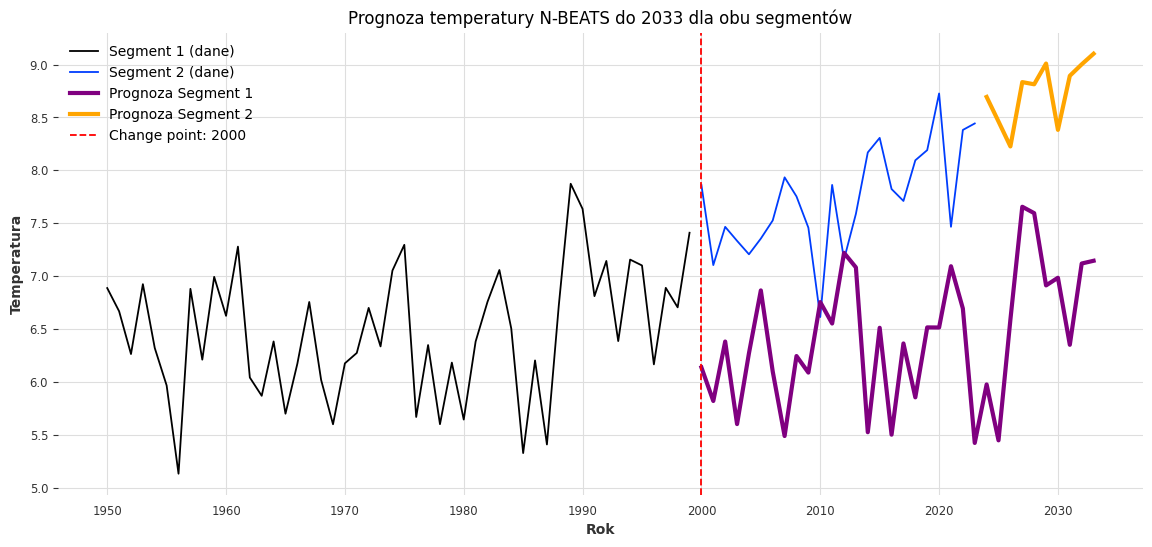

In [46]:
#  Wizualizacja
plt.figure(figsize=(14,6))

# Oryginalne dane
plt.plot(ts1.time_index, ts1.values(), label="Segment 1 (dane)")
plt.plot(ts2.time_index, ts2.values(), label="Segment 2 (dane)")

# Prognozy
plt.plot(forecast1.time_index, forecast1.values().flatten(), label="Prognoza Segment 1", lw=3, color='purple')
plt.plot(forecast2.time_index, forecast2.values().flatten(), label="Prognoza Segment 2", lw=3, color='orange')

plt.axvline(break_year, color='red', linestyle='--', label=f"Change point: {break_year}")

plt.title("Prognoza temperatury N-BEATS do 2033 dla obu segmentów")
plt.xlabel("Rok")
plt.ylabel("Temperatura")
plt.legend()
plt.grid(True)

start_year = min(ts1.time_index[0], ts2.time_index[0])
end_year = max(forecast2.time_index[-1], ts2.time_index[-1])
plt.xticks(np.arange(start_year, end_year + 1, 10))

plt.show()


#### Różnica między prognozą na podstawie Segmentu 1 a rzeczywistym Segment 2

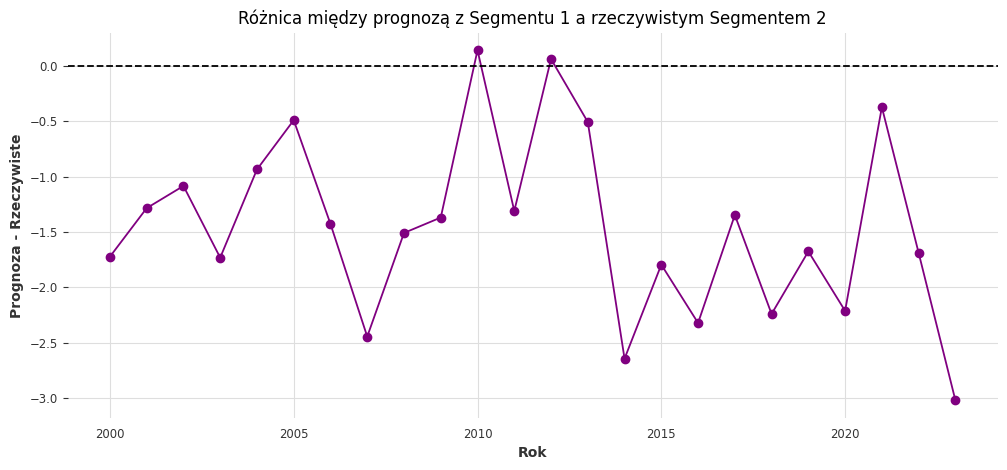

Średnia różnica: -1.4559716435786594


In [47]:

# Dopasowanie długości prognozy do segmentu 2
forecast_for_segment2 = forecast1[:len(segment2)]

# Różnica prognoza - rzeczywiste wartości
diff = forecast_for_segment2.values().flatten() - segment2["temp"].values

# Wykres różnicy
plt.figure(figsize=(12,5))
plt.plot(segment2["year"], diff, marker='o', linestyle='-', color='purple')
plt.axhline(0, color='black', linestyle='--')  # linia odniesienia 0
plt.title("Różnica między prognozą z Segmentu 1 a rzeczywistym Segmentem 2")
plt.xlabel("Rok")
plt.ylabel("Prognoza - Rzeczywiste")
plt.grid(True)
plt.show()

# Średnia różnica
mean_diff = diff.mean()
print("Średnia różnica:", mean_diff)
